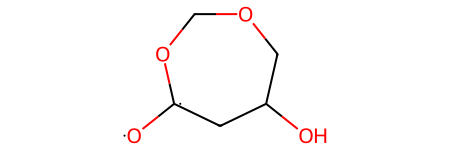

9
9
9
9
tensor([[2., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 1., 0., 2.],
        [0., 2., 0., 1.],
        [2., 0., 0., 1.],
        [0., 1., 0., 2.],
        [2., 1., 0., 0.],
        [0., 1., 0., 2.],
        [2., 1., 0., 0.]])
tensor([[0, 1, 1, 2, 2, 3, 3, 4, 3, 5, 5, 6, 6, 7, 7, 8, 8, 1],
        [1, 0, 2, 1, 3, 2, 4, 3, 5, 3, 6, 5, 7, 6, 8, 7, 1, 8]])
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
torch.Size([300, 1600])
torch.Size([18, 1600])
torch.Size([1600])
4.542902902140598e-14
True
9
18
torch.Size([9, 1600])
ITERATIONS: 18
Edge 0 done
Sim max: 0.7490727842160757
Edge 1 done
Sim max: 0.6095282557366755
Edge 2 done
Sim max: 0.6593857140683818
Edge 3 done
Sim max: 0.4507840139272349
Edge 4 done
Sim max: 0.4730925234213882
Edge 5 done
Sim max: 0.4939945456993436
Edge 6 done
Sim max: 0.5817664880936574
Edge 7 done
Sim max: 0.6848822814531254
Edge 8 done
Sim max: 1.0
18
Counter({((0,

KeyboardInterrupt: 

In [1]:
from collections import Counter
import itertools

from torch_geometric.data import Batch
import torch
import torchhd

from src.datasets.qm9_smiles_generation import QM9Smiles
from src.encoding.configs_and_constants import QM9_SMILES_HRR_1600_CONFIG
from src.encoding.graph_encoders import load_or_create_hypernet
from src.utils.utils import DataTransformer, GLOBAL_MODEL_PATH, TupleIndexer, pick_device

ds = QM9Smiles(split="test")


data = ds[64]

nx_g = DataTransformer.pyg_to_nx(data)
mol, _ = DataTransformer.nx_to_mol_v2(nx_g, dataset="qm9")

display(mol)
print(mol.GetNumAtoms())
print(mol.GetNumBonds())
print(nx_g.number_of_nodes())
print(nx_g.number_of_edges())
print(data.x)
print(data.edge_index)

device = pick_device()

node_tuples = [tuple(i) for i in data.x.tolist()]
edge_tuples = [tuple(e) for e in data.edge_index.t().cpu().tolist()]

ds_config = QM9_SMILES_HRR_1600_CONFIG
encoder = load_or_create_hypernet(GLOBAL_MODEL_PATH, cfg=ds_config)
node_cb = encoder.nodes_codebook
node_cb = node_cb.to(torch.float64).as_subclass(torchhd.HRRTensor)
print(node_cb.shape)
node_idxer: TupleIndexer = encoder.nodes_indexer


# Manually compute the edge terms
edget_terms_manual = None
edges = []
for a, b in edge_tuples:
    idx_a = node_idxer.get_idx(node_tuples[a])
    idx_b = node_idxer.get_idx(node_tuples[b])
    hd_a = node_cb[idx_a]
    hd_b = node_cb[idx_b]

    # bind
    edges.append(hd_a.bind(hd_b))

t = torch.stack(edges)
print(t.shape)
edget_terms_manual = torchhd.multibundle(t)
print(edget_terms_manual.shape)

edget_terms_m_copy = edget_terms_manual.clone()
# Now just reverse to see if you get 0
for a, b in edge_tuples:
    idx_a = node_idxer.get_idx(node_tuples[a])
    idx_b = node_idxer.get_idx(node_tuples[b])
    hd_a = node_cb[idx_a]
    hd_b = node_cb[idx_b]

    # bind
    edget_terms_m_copy -= hd_a.bind(hd_b)

zero_hd = torchhd.empty(1, 1600, "HRR")
sum_elements = edget_terms_m_copy.abs().sum().item()
print(sum_elements)
# prints 2.470420440658927e-05 <-- why not zero?
# with dtype floa64 -> 4.542902902140598e-14 almost zero

# Compare the manually created one with the hypernet

batch = Batch.from_data_list([data])
edge_terms = encoder.forward(batch)["edge_terms"]

eps = 1e-6
ok_mask = (edge_terms - edget_terms_manual).abs() <= eps         # bool tensor
all_ok = ok_mask.all() # << GOOD
print(all_ok.item())


## Now let's fucking decode the edges
node_counter = DataTransformer.get_node_counter_from_batch(0, batch)
num_edges = sum([(e_idx+1) * n for (_, e_idx, _, _), n in node_counter.items()])

n_count = node_counter.total()
e_count = num_edges
print(n_count)
print(e_count)

node_idxs = node_idxer.get_idxs(node_tuples)
idx_tensor = torch.tensor(node_idxs, dtype=torch.long, device=device)
cb = node_cb[idx_tensor]
print(cb.shape)

working_node_counter = node_counter.copy()
residuals = {k:(k[1]+1) * n * 2 for k, n in node_counter.items()} # how much each node can spend on edges
edges_left = [(node_tuples[a], node_tuples[b]) for a, b in edge_tuples]
working_edge_terms = edget_terms_manual.clone().as_subclass(torchhd.HRRTensor)
working_node_tuples = node_tuples.copy()
result = Counter()
print(f"ITERATIONS: {e_count}")
tuple_to_idx = {t: i for i, t in enumerate(working_node_counter.keys())}
result_edge_index = []
black_list = set()
for i in range(e_count // 2):
    edges = []
    all_edges = list(itertools.product(working_node_counter.keys(), working_node_counter.keys()))
    for a, b in all_edges:
        # if a == b: continue
        idx_a = node_idxer.get_idx(a)
        idx_b = node_idxer.get_idx(b)
        hd_a = node_cb[idx_a]
        hd_b = node_cb[idx_b]

        # bind
        edges.append(hd_a.bind(hd_b))

    t = torch.stack(edges).as_subclass(torchhd.HRRTensor)
    sims = torchhd.cos(working_edge_terms, t)
    idx = torch.argmax(sims)
    eps = 1e-9
    max_idxs = (sims >= sims.max() - eps).nonzero(as_tuple=True)[0]
    a_found, b_found = None, None
    for idx in max_idxs:
        if idx in black_list:
            continue
        a_found, b_found = all_edges[idx]
        if residuals[a_found] <= 0:
            continue
        if residuals[b_found] <= 0:
            continue
        if (a_found, b_found) not in edges_left:
            print("ALARM")
        break

    if not a_found or not b_found:
        print("Failed to decode")
        break
    edges_left.remove((a_found, b_found))
    edges_left.remove((b_found, a_found))
    hd_a_found = node_cb[node_idxer.get_idx(a_found)]
    hd_b_found = node_cb[node_idxer.get_idx(b_found)]
    working_edge_terms -= hd_a_found.bind(hd_b_found)
    working_edge_terms -= hd_b_found.bind(hd_a_found)
    result[(a_found, b_found)] += 1
    result[(b_found, a_found)] += 1

    residuals[a_found] -= 2
    residuals[b_found] -= 2

    result_edge_index.append((a_found, b_found))
    result_edge_index.append((b_found, a_found))
    print(f"Edge {i} done")
    print(f"Sim max: {sims.max().item()}")


print(result.total())
print(result)
print(result_edge_index)
print("ENCODED")
e_c = Counter(result_edge_index)
print(sorted(e_c.items(), key=lambda x: x[1], reverse=True))
print("ACTUAL")
a_c = Counter([(node_tuples[a], node_tuples[b]) for a, b in edge_tuples])
print(sorted(a_c.items(), key=lambda x: x[1], reverse=True))


encoded_nodes = []
encoded_edge_indexes = []
node_indexes = {}
idx = 0
residuals_left = []
actual_edges = [(node_tuples[a], node_tuples[b]) for a, b in edge_tuples]
for i, (a, b) in enumerate(result_edge_index):
    if i % 2 == 1:
        continue
    i_a, i_b = -1, -1
    for i, (n, r) in enumerate(zip(encoded_nodes, residuals_left)):
        if n == a and r >= 0:
            i_a = i
        if n == b and r >= 0:
            i_b = i
    if (i_a, i_b) not in encoded_edge_indexes:
        if i_a == -1:
            encoded_nodes.append(a)
            residuals_left.append(a[1] + 1)
            i_a = idx
            idx += 1
        if i_b == -1:
            encoded_nodes.append(b)
            residuals_left.append(b[1] + 1)
            i_b = idx
            idx += 1
    else:

    encoded_edge_indexes.append((i_a, i_b))
    encoded_edge_indexes.append((i_b, i_a))
    residuals_left[i_a] -= 1
    residuals_left[i_b] -= 1
